In [1]:
import json
import os
import glob
import pprint

 
count = 0
answers_dict = {'narr_answers': []}
path = r'C:\\Users\\maganti\\Documents\\INFO 5502 Chen Sir Project UNT\\Web Scraping Interviews\\Narrators Json Files-With Q&A'
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.     
    #print(filename)
    narrators_answers_corpus = ""
    with open(filename, mode = 'rb') as currentFile:
        data = json.loads(currentFile.read())
        try:
            if data['transcript'] != {}:
                for segment in data["transcript"].keys():
                    for question in data["transcript"][segment]['Segment Q&A'].keys():
                        narrators_answers_corpus = narrators_answers_corpus + " " + data["transcript"][segment]['Segment Q&A'][question]
                        count = count + 1                
            else:
                pass
        except Exception as e:
            print(e)
            
    answers_dict['narr_answers'].append(narrators_answers_corpus) 

print()


In [2]:
import pandas as pd
df = pd.DataFrame(answers_dict)
df['narr_answers'] = df['narr_answers'].str.lower()
print(df['narr_answers'].shape)

(1042,)


In [3]:
df['narr_answers'] = df['narr_answers'].str.replace('[^a-zA-Z0-9 ]', '')

C:\Users\maganti\AppData\Local\Temp/ipykernel_35804/1017421635.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['narr_answers'] = df['narr_answers'].str.replace('[^a-zA-Z0-9 ]', '')


In [5]:
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import pandas as pd
import gensim
import re
import pyLDAvis#.gensim
import pyLDAvis.gensim_models
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['clean_narr_answers'] = df['narr_answers'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maganti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re
#my_list= ["on@3", "two#", "thre%e"]
stop_words = [re.sub('[^a-zA-Z0-9]+', '', word) for word in stop_words]

In [10]:
texts = []
lemmatizer = WordNetLemmatizer()
# loop through document list
for i in df['clean_narr_answers']:
    # clean and tokenize document string
    #raw = str(i[1]).lower()
    #tokens = tokenizer.tokenize(raw)
    tokens = i.split()
    # remove stop words from tokens
    #stop_words = stopwords.words('english')
    #stopped_tokens = [raw for raw in tokens if not raw in stop_words]
    
    # remove stop words from tokens
    #stopped_tokens_new = [raw for raw in stopped_tokens if not raw in remove_words]
    
    # lemmatize tokens
    
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # remove word containing only single char
    new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]
    
    lemmatized_string = " ".join(token for token in new_lemma_tokens)
    
    
    import nltk
    #word_data = "The best performance can bring in sky high success."
    nltk_tokens = nltk.word_tokenize(lemmatized_string)
    #print(list(nltk.bigrams(nltk_tokens)))
    texts.append([ele[0]+ " " + ele[1] for ele in list(nltk.bigrams(nltk_tokens))])

# sample data
#print(texts[8])

In [11]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [12]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=14, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=5))

[([(1.1045491e-05, 'say avoided'),
   (1.1045438e-05, 'child listening'),
   (1.10453275e-05, 'listening whatever'),
   (1.1045308e-05, 'complain amongst'),
   (1.104521e-05, 'amongst probably')],
  1.0420000412636637e-09),
 ([(0.00010604155, 'mr aebi'),
   (5.184417e-05, 'francis aebi'),
   (4.095584e-05, 'jefferson city'),
   (4.0938838e-05, 'mechanic bank'),
   (4.09341e-05, 'mr koda')],
  1.0420000412636637e-09),
 ([(6.63627e-05, 'clyde black'),
   (5.551464e-05, 'mountain home'),
   (4.4473833e-05, 'stan thompson'),
   (4.431699e-05, 'stol holt'),
   (4.1789222e-05, 'central issue')],
  1.0420000412636637e-09),
 ([(0.0068629747, 'dont know'),
   (0.0023714276, 'high school'),
   (0.001963392, 'dont think'),
   (0.0019247422, 'gon na'),
   (0.001851003, 'didnt know')],
  -0.2062531049444154),
 ([(5.6949662e-05, 'department justice'),
   (3.2849643e-05, 'bob joanne'),
   (3.2337644e-05, 'folk involved'),
   (2.2075285e-05, 'unique case'),
   (2.2073826e-05, 'federal employee')],
  -

In [13]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.380191000978822

Coherence Score:  0.3800143920644063


In [14]:
import pyLDAvis.gensim_models
#from pyLdAvis import gensim_models
# don't skip this
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
#pyLDAvis.show(vis)
pyLDAvis.display(vis)

C:\Users\maganti\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [15]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9990,"dont know, high school, dont think, gon na, di...","[well name, name aaron, aaron zajic, zajic rol..."
1,1,1.0,0.9998,"dont know, high school, dont think, gon na, di...","[born august, august 1924, 1924 sacramento, sa..."
2,2,1.0,0.9492,"dont know, high school, dont think, gon na, di...","[asian american, american action, action group..."
3,3,1.0,0.8728,"dont know, high school, dont think, gon na, di...","[family mean, mean father, father father, fath..."
4,4,1.0,0.9997,"dont know, high school, dont think, gon na, di...","[kamesuke yabiku, yabiku kama, kama yabiku, ya..."
5,5,1.0,0.9997,"dont know, high school, dont think, gon na, di...","[mother grew, grew kumamoto, kumamoto japan, j..."
6,6,1.0,0.9995,"dont know, high school, dont think, gon na, di...","[well always, always parent, parent positive, ..."
7,7,1.0,0.9998,"dont know, high school, dont think, gon na, di...","[yes permission, permission father, father tsu..."
8,8,1.0,0.9815,"dont know, high school, dont think, gon na, di...","[war living, living family, family guess, gues..."
9,9,1.0,0.9996,"dont know, high school, dont think, gon na, di...","[farming uhhuh, uhhuh war, war farming, farmin..."


In [16]:
df_dominant_topic.to_csv('14 Topics Summary.csv',index=False)

In [17]:
df_dominant_topic['Dominant_Topic'].value_counts()

1.0     912
0.0      98
12.0      9
10.0      8
13.0      5
8.0       3
6.0       3
11.0      2
7.0       1
4.0       1
Name: Dominant_Topic, dtype: int64

<AxesSubplot:>

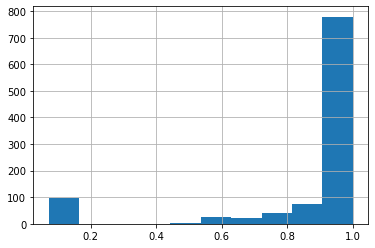

In [54]:
df_dominant_topic['Topic_Perc_Contrib'].hist()

In [57]:
df_dominant_topic[df_dominant_topic['Topic_Perc_Contrib'] < 0.5].shape

(97, 5)

In [18]:
ldamodel.top_topics(corpus,topn=30)

[([(0.00010604155, 'mr aebi'),
   (5.184417e-05, 'francis aebi'),
   (4.095584e-05, 'jefferson city'),
   (4.0938838e-05, 'mechanic bank'),
   (4.09341e-05, 'mr koda'),
   (2.9988072e-05, 'closed nursery'),
   (2.9969366e-05, 'move livingston'),
   (2.9964212e-05, 'trip colombia'),
   (2.9960773e-05, 'industry california'),
   (2.9957635e-05, 'ray hasek'),
   (2.9955187e-05, 'held mechanic'),
   (2.9919143e-05, 'family richmond'),
   (1.8757715e-05, 'growing rose'),
   (1.8753242e-05, 'house nursery'),
   (1.8742521e-05, 'rose grower'),
   (1.8735931e-05, 'theyre becoming'),
   (1.8734181e-05, 'plant business'),
   (1.8730134e-05, 'horticulture department'),
   (1.8718527e-05, 'living richmond'),
   (1.8714569e-05, 'pretty hardy'),
   (1.8711606e-05, 'took greenhouse'),
   (1.8700137e-05, 'livingston early'),
   (1.8693878e-05, 'leave nursery'),
   (1.8688443e-05, 'country growing'),
   (1.8688334e-05, 'pat suzuki'),
   (1.8683611e-05, 'property farmer'),
   (1.868347e-05, 'equipment t